# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

### Import packages and ModelClass

In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data for equivalence scale and life cycle income profile

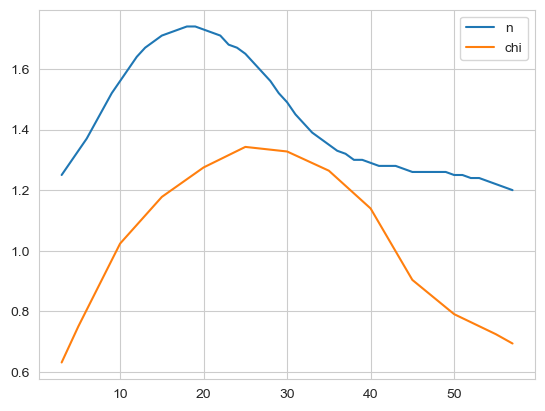

In [28]:
#wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# interpolate income profile and slice
data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

# plot data
data.plot(y=['n','chi'])
plt.show()

## Baseline model

In [29]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':10, 
        #'nu':0.4,
        #'alpha':2,
        'kappa':0.0, # no utility cost of moving
        'thetab':170,
        'K':7.7, 
        'phi':0.5,
        'gamma':0.06,
        'omega_ltv':0.9,
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve(do_assert=True)
model_baseline.simulate()
#model_baseline.save()

negative net cash-on-hand for refinancers ocurred the following amount of times:
18
negative net cash-on-hand for buyers ocurred the following amount of times:
19
 t = 3 solved in 64.7 secs
negative net cash-on-hand for refinancers ocurred the following amount of times:
18
negative net cash-on-hand for buyers ocurred the following amount of times:
19
 t = 2 solved in 50.9 secs
negative net cash-on-hand for refinancers ocurred the following amount of times:
18
negative net cash-on-hand for buyers ocurred the following amount of times:
19
 t = 1 solved in 0.0 secs
negative net cash-on-hand for refinancers ocurred the following amount of times:
18
negative net cash-on-hand for buyers ocurred the following amount of times:
19
 t = 0 solved in 0.0 secs
 total precomputation time  = 66.5 secs
 total stay-time  = 11.6 secs
 total ref-time   = 13.7 secs
 total buy-time   = 18.4 secs
 total rent-time   = 5.5 secs
 full model solved in = 115.6 secs
model simulated in 48.7 secs
numba precompiled 

### Decision Functions

In [51]:
import figs
figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [59]:
# check if renter utility is identical for different rental choices
par = model_baseline.par 
sol = model_baseline.sol 

t = 0
iw = 2
im = 5
print(f'inverse value functions for renters with t= {t}, i_w = {iw} and i_m = {im}:')
print(sol.inv_v_rent[t,0,iw,im],sol.inv_v_rent[t,1,iw,im],sol.inv_v_rent[t,2,iw,im])

# check stayer solution is 0 for all non-positive values of net cash-on-hand
print()
print(f'mean value function of stayers for m_t=0 is {np.mean(sol.inv_v_stay[:,:,:,:,:,:,0])}')


inverse value functions for renters with t= 0, i_w = 2 and i_m = 5:
0.005275341225319561 0.005278089874381774 0.005280791809681652

mean value function of stayers for m_t=0 is 0.0


### Life Cycle Behaviour

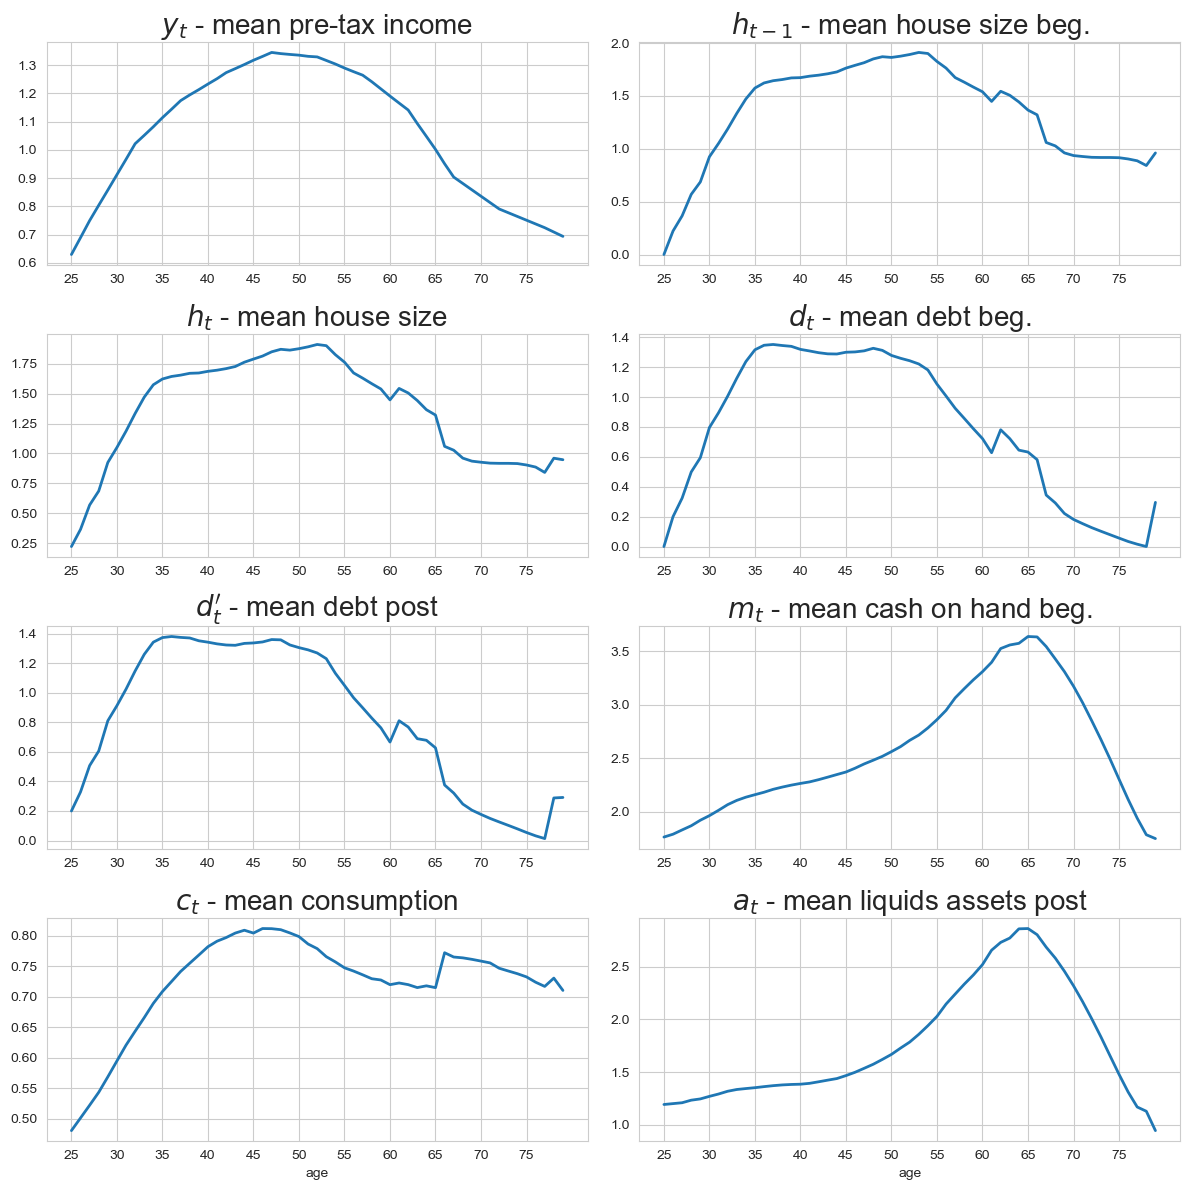

In [31]:
import figs

# average behaviour over the life cycle
figs.lifecycle(model_baseline)

In [46]:

sim = model_baseline.sim 
par = model_baseline.par

# validation check simulation
I = sim.c < 0 # negative consumption?
D = sim.d > 0 # take mortgage?
DA = sim.Tda > 0 # choose deferred amortisation?

# output from checks
print(f'there are {np.sum(I)} cases of negative consumption.') 
print(f'ref accounts for {np.sum(I*(sim.discrete==1))} and buy for {np.sum(I*(sim.discrete==2))}.')
print(f'stay accounts for {np.sum(I*(sim.discrete==0))} and rent for {np.sum(I*(sim.discrete==3))}')
print(f'the share of negative consumption cases is {np.sum(I)/(par.simN*par.T)}')
print()
print('negative simulated consumption occurs in periods:')
print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[0])
print('and cases per period are:')
print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[1])
print()
print('the distribution of house choices is:')
print(np.unique(sim.h,return_counts=True))
print()
print('the distribution of rental choices is:')
print(np.unique(sim.h_tilde,return_counts=True))
print()
print('the distribution of DA periods is:')
print(np.unique(sim.Tda,return_counts=True))
print(f'and the share of DA mortgages is {np.sum(DA)/np.sum(D):4f}')



there are 663 cases of negative consumption.
ref accounts for 663 and buy for 0.
stay accounts for 0 and rent for 0
the share of negative consumption cases is 0.00012054545454545454

negative simulated consumption occurs in periods:
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 36]
and cases per period are:
[ 1  4 11  5  8  2 20 21 32 31 33 42 66 72 30 65 99 50 68  3]

the distribution of house choices is:
(array([0.  , 5.91]), array([4251227, 1248773]))

the distribution of rental choices is:
(array([0.  , 1.07, 1.42, 1.89]), array([1309322, 1110623,  445654, 2634401]))

the distribution of DA periods is:
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([5498088,    1025,     419,      78,      78,      78,      78,
            78,      78]))
and the share of DA mortgages is 0.001554


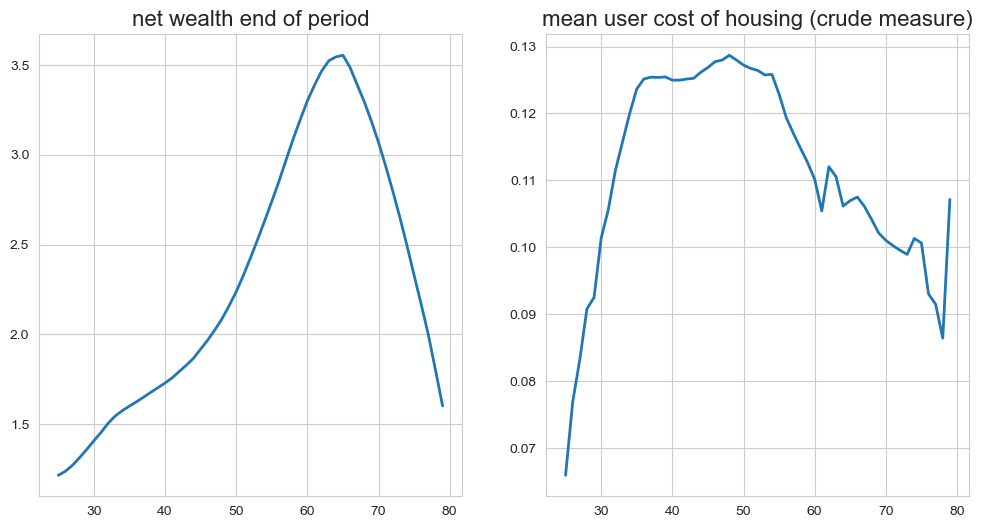

In [48]:
par = model_baseline.par
sim = model_baseline.sim

# x axis
age = np.arange(par.T)+par.Tmin

# compute net wealth
net_wealth = sim.a+sim.h_prime-sim.d_prime

# compute user cost
bool_stay = sim.discrete == 0
bool_ref = sim.discrete == 1
bool_buy = sim.discrete == 2
bool_rent = sim.discrete == 3
bool_da = sim.Tda > 0

rent_cost = bool_rent*par.q_r*sim.h_tilde
own_cost = (bool_stay+bool_ref)*(par.delta+par.tau_h0)*par.q*sim.h + bool_da*par.r_da*sim.d + (1-bool_da)*par.r_m*sim.d

user_cost = rent_cost + own_cost

### add two-bracket property tax later

# plot
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
ax.plot(age,np.mean(net_wealth,axis=1),lw=2)
ax.set_title('net wealth end of period',fontsize=16)

ax = fig.add_subplot(1,2,2)
ax.plot(age,np.mean(user_cost,axis=1),lw=2)
ax.set_title('mean user cost of housing (crude measure)',fontsize=16);

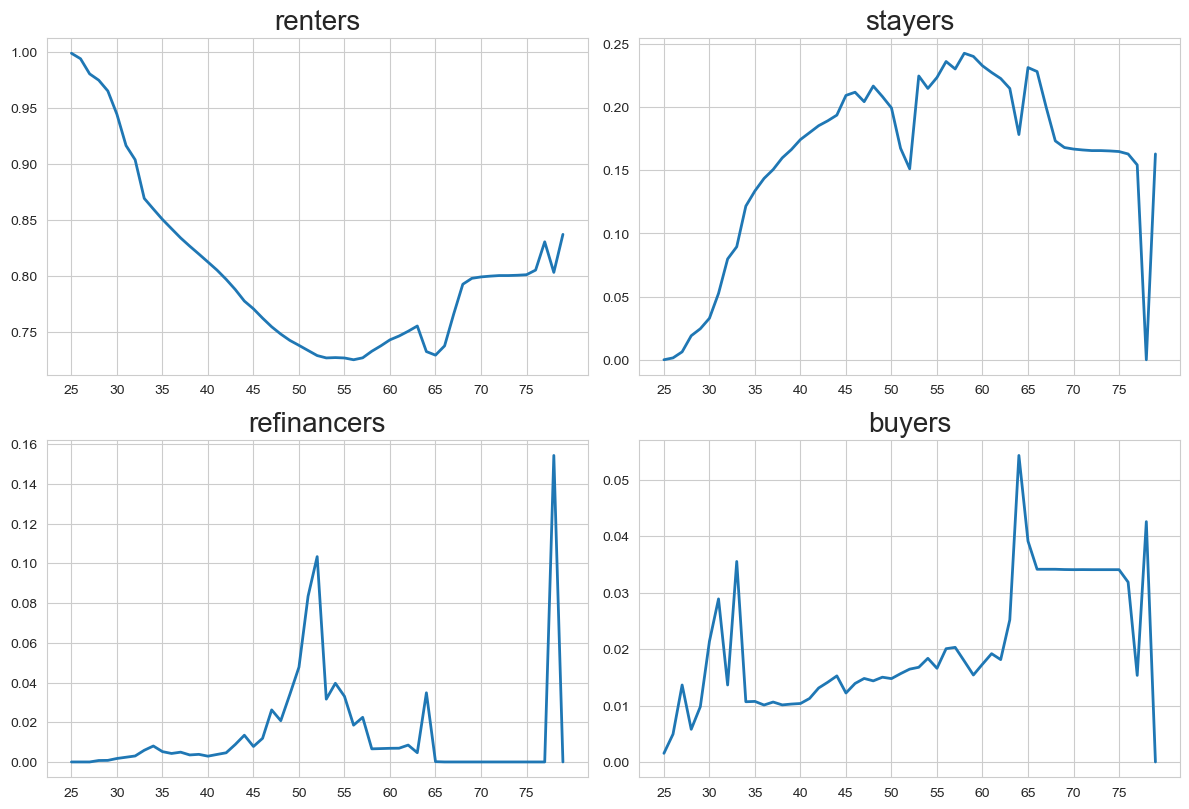

In [23]:
figs.homeownership(model_baseline)

In [24]:
import trans

# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# b. allocate containers and compute shares
own_share = np.zeros(par.T)
stay_share = np.zeros(par.T)
ref_share = np.zeros(par.T)
buy_share = np.zeros(par.T)
rent_share = np.zeros(par.T)

for t in range(par.T):
    stay_share[t] = np.sum(sim.discrete[t]==0)/par.simN
    ref_share[t] = np.sum(sim.discrete[t]==1)/par.simN
    buy_share[t] = np.sum(sim.discrete[t]==2)/par.simN
    rent_share[t] = np.sum(sim.discrete[t]==3)/par.simN
    own_share[t] = 1-rent_share[t]

print(f'mean homeownership rate is {np.mean(own_share):.4f}')


mean homeownership rate is 0.1952


### Loop to match bequest level with initial wealth

In [12]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 113561.2615
total bequest is 176540.1656
mean bequest is 1.7654
average hh pre-tax income is 711043.7947


In [44]:
# agggregate housing demand
H_d = np.sum(sim.h) + np.sum(sim.h_tilde)
print(f'aggregate housing demand for purchase and rental is {H_d:.4f}')

aggregate housing demand for purchase and rental is 16759459.7500


In [60]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

iteration = 1, discrepancy = 0.109966
iteration = 2, discrepancy = 0.048106
iteration = 3, discrepancy = 0.021102
iteration = 4, discrepancy = 0.009236
iteration = 5, discrepancy = 0.004032
iteration = 6, discrepancy = 0.001749
iteration = 7, discrepancy = 0.000780
iteration = 8, discrepancy = 0.000330
iteration = 9, discrepancy = 0.000150
iteration = 10, discrepancy = 0.000066
iteration = 11, discrepancy = 0.000028
iteration = 12, discrepancy = 0.000012
iteration = 13, discrepancy = 0.000006
iteration = 14, discrepancy = 0.000003
iteration = 15, discrepancy = 0.000001
iteration = 16, discrepancy = 0.000001
convergence achieved in 16 simulations, mean bequest = 0.344225


### Test solving the household problem for a few periods

In [26]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

post decision is done
stay is done
negative net cash-on-hand for refinancers ocurred the following amount of times:
420
refinance is done
negative net cash-on-hand for buyers ocurred the following amount of times:
476
buy is done
rent is done
start solving t=53
post decision is done
stay is done
negative net cash-on-hand for refinancers ocurred the following amount of times:
420
refinance fast is done
negative net cash-on-hand for buyers ocurred the following amount of times:
476
buy fast is done
rent is done


### Sanity checks

In [62]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

nan_mat_q = np.argwhere(np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]))
print(f'size of q at t={t} is {sol.q[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
print(f'there are {nan_mat_q.shape[0]} NaN entries')
print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} with Tda in 0,1,2 is {sol.q[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


size of q at t=53 is 264600
there are 0 NaN entries
the nan indices are []
size of q at t=53 with Tda in 0,1,2 is 264600
there are 37730 zero or negative entries
the zero indices/negative are [[ 0  0  0  1  0  0]
 [ 0  0  0  1  0  1]
 [ 0  0  0  1  0  2]
 ...
 [ 0  9 26  1  6  7]
 [ 0  9 26  1  6  8]
 [ 0  9 26  1  6  9]]


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')

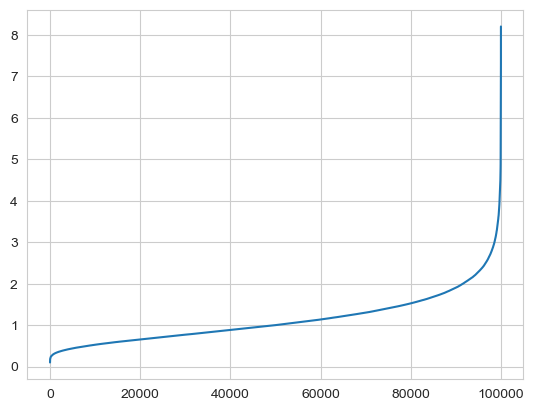

In [13]:
plt.plot(np.sort(sim.a0))